<a href="https://colab.research.google.com/github/LuizFelipe2812/Mestrado_FACOM/blob/main/Implementa%C3%A7%C3%A3o_CNN_Luiz_Felipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo Teste para implementação

Este modelo inicial é um baseline, utilizando as bases de dados presente no Keras.

In [ ]:
"""
Importação das bibliotecas necessárias para implementação

"""

import numpy as np
import pandas as pd
import os
import sklearn
import tensorflow.keras

from matplotlib import pyplot
from PIL import Image
from tensorflow.keras import utils as np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from keras.datasets import cifar10


In [ ]:
# Carregando dataset que será utilizado
(trainX, trainY), (testX, testY) = cifar10.load_data()

170498071/170498071 [==============================] - 11s 0us/step


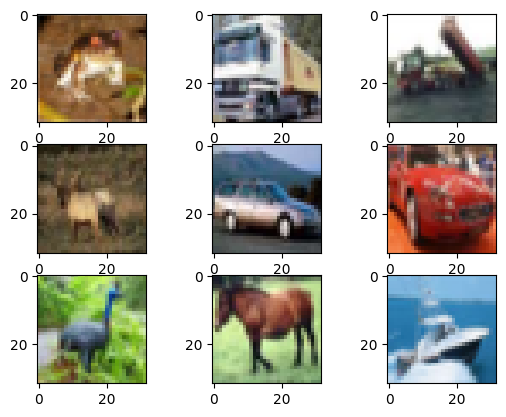

In [ ]:
# Plotando algumas imagens do Dataset
for i in range(9):
 pyplot.subplot(330 + 1 + i)
 pyplot.imshow(trainX[i])
pyplot.show()

In [ ]:
# Pré-processamento dos dados
trainX = trainX.astype('float32') / 255.0
testX = testX.astype('float32') / 255.0
trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

In [ ]:
# Gera uma função para segmentar o dataset em dados de treino e teste
"""
def load_dataset():
 # carrega o dataset
 (trainX, trainY), (testX, testY) = cifar10.load_data()

 trainY = to_categorical(trainY)
 testY = to_categorical(testY)
 return trainX, trainY, testX, testY """

'\ndef load_dataset():\n # carrega o dataset\n (trainX, trainY), (testX, testY) = cifar10.load_data()\n\n trainY = to_categorical(trainY)\n testY = to_categorical(testY)\n return trainX, trainY, testX, testY '

In [ ]:
# Construir o modelo da CNN

model = Sequential() # Cria um modelo Sequential, que é uma pilha linear de camadas de rede neural.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3))) # Adiciona uma camada de convolução Conv2D à rede
model.add(MaxPooling2D((2, 2))) # Adiciona uma camada de pooling
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5)) # Para evitar o overfitting, adicionamos uma camada de Dropout
model.add(Dense(10, activation='softmax'))


In [ ]:
# Compilar o modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

In [ ]:
# Treinar o modelo
history = model.fit(trainX, trainY,
          epochs=10,      # Indica o número de épocas de treinamento
          batch_size=128, #  Define o tamanho do lote (batch size) utilizado durante o treinamento.
          validation_split=0.1 # Proporção da base de validação
          )

Epoch 1/10
352/352 [==============================] - 71s 202ms/step - loss: 0.8372 - accuracy: 0.7104 - val_loss: 0.8408 - val_accuracy: 0.7098
Epoch 2/10
352/352 [==============================] - 69s 195ms/step - loss: 0.8122 - accuracy: 0.7197 - val_loss: 0.8195 - val_accuracy: 0.7220
Epoch 3/10
352/352 [==============================] - 68s 193ms/step - loss: 0.7761 - accuracy: 0.7320 - val_loss: 0.8091 - val_accuracy: 0.7246
Epoch 4/10
352/352 [==============================] - 70s 198ms/step - loss: 0.7557 - accuracy: 0.7364 - val_loss: 0.8136 - val_accuracy: 0.7234
Epoch 5/10
352/352 [==============================] - 67s 190ms/step - loss: 0.7229 - accuracy: 0.7479 - val_loss: 0.8057 - val_accuracy: 0.7270
Epoch 6/10
352/352 [==============================] - 67s 190ms/step - loss: 0.7029 - accuracy: 0.7543 - val_loss: 0.7862 - val_accuracy: 0.7334
Epoch 7/10
352/352 [==============================] - 69s 197ms/step - loss: 0.6779 - accuracy: 0.7638 - val_loss: 0.7955 - val_ac

In [ ]:
# Avaliar o modelo
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7981677055358887
Test accuracy: 0.7282000184059143


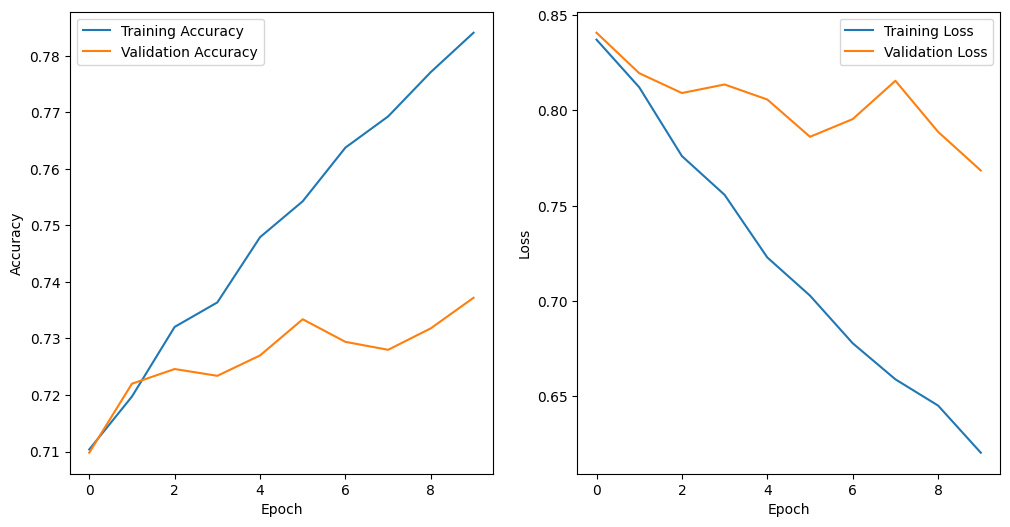

In [ ]:
import matplotlib.pyplot as plt

# Plotar curvas de aprendizado
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Model Evaluation Test Harness

In [94]:
"""
Importação das bibliotecas necessárias para implementação

"""

import numpy as np
import pandas as pd
import os
import sklearn
import tensorflow.keras

from matplotlib import pyplot
from PIL import Image
from tensorflow.keras import utils as np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import Model
from keras.datasets import cifar10

In [95]:
# Carregando dataset que será utilizado
(trainX, trainY), (testX, testY) = cifar10.load_data()

In [96]:
# Pré-processamento dos dados
trainX = trainX.astype('float32') / 255.0
testX = testX.astype('float32') / 255.0
trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)

In [97]:
model = Sequential() # Cria um modelo Sequential, que é uma pilha linear de camadas de rede neural.

# Camadas de convolução e max pooling
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

# Camadas totalmente conectadas
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))  # Camada de saída com 10 unidades e softmax


In [98]:
# Compilar o modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

In [99]:
"""
ValueError: Shapes (None, 10) and (None, 32, 32, 3) are incompatible

Retorna o seguinte erro:

O erro que você está enfrentando é devido a uma incompatibilidade entre as dimensões
dos dados de entrada e saída na função de perda categorical_crossentropy.
 """


# fit model
history = model.fit(trainX, trainY,
                    epochs=10,
                    batch_size=64,  #  Define o tamanho do lote (batch size) utilizado durante o treinamento.
                    validation_data=(testX, testY), verbose=0)

In [100]:
# Avaliar o modelo
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.797690212726593
Test accuracy: 0.7267000079154968


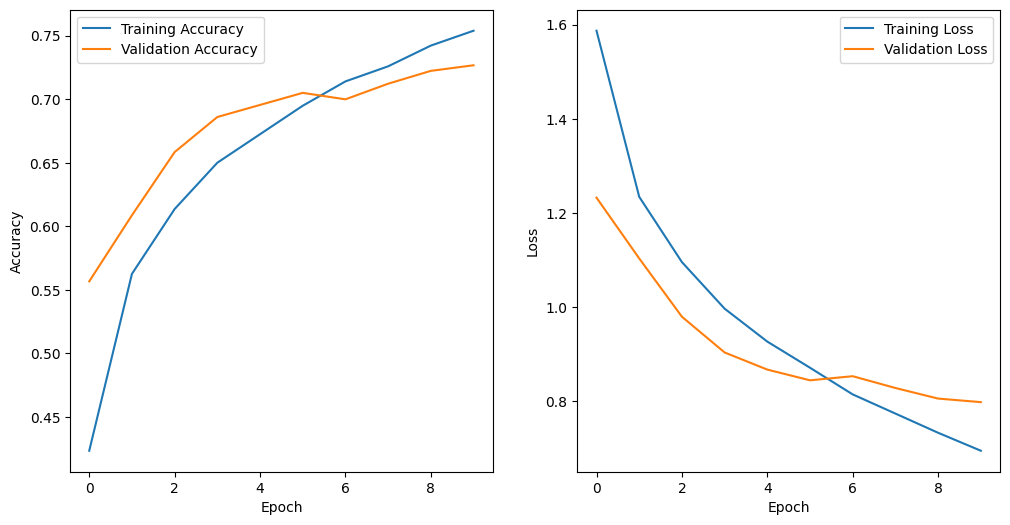

In [102]:
import matplotlib.pyplot as plt

# Plotar curvas de aprendizado
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Desenvolvendo Modelo Baseline

Utilizando 1 VGG

In [103]:
# define cnn model
def define_model():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dense(10, activation='softmax'))
 # compile model
 opt = SGD(lr=0.001, momentum=0.9)
 model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
 return model

In [105]:

# fit model
history_1vgg = model.fit(trainX, trainY,
                         epochs=10,
                         batch_size=64,
                         validation_data=(testX, testY),
                         verbose=0)

In [106]:
# Avaliar o modelo
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.9218991994857788
Test accuracy: 0.7310000061988831


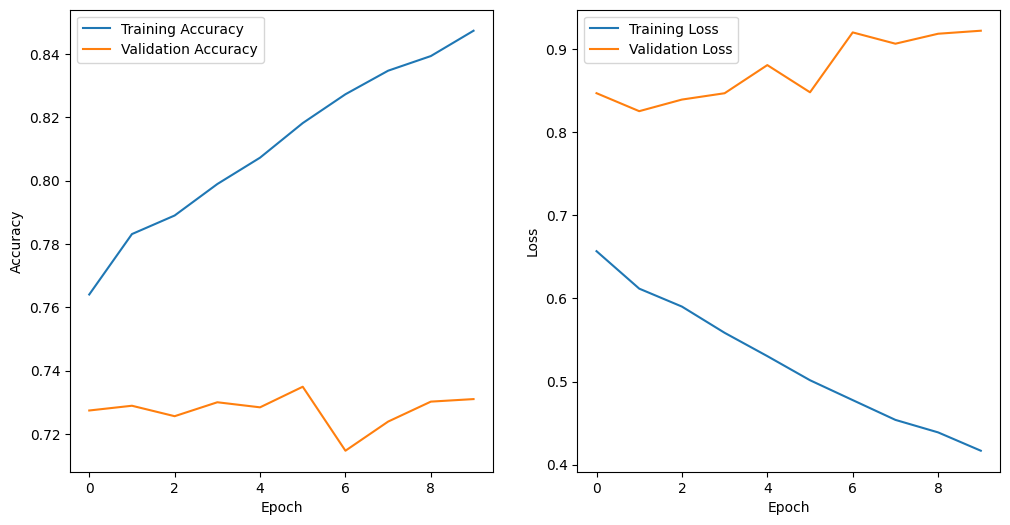

In [107]:
import matplotlib.pyplot as plt

# Plotar curvas de aprendizado
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_1vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_1vgg.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_1vgg.history['loss'], label='Training Loss')
plt.plot(history_1vgg.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Utilizando 2 VGG

In [108]:
# define cnn model
def define_model():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dense(10, activation='softmax'))
 # compile model
 opt = SGD(lr=0.001, momentum=0.9)
 model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
 return model

In [109]:
# fit model
history_2vgg = model.fit(trainX, trainY,
                         epochs=10,
                         batch_size=64,
                         validation_data=(testX, testY),
                         verbose=0)

In [110]:
# Avaliar o modelo
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.1635372638702393
Test accuracy: 0.7250000238418579


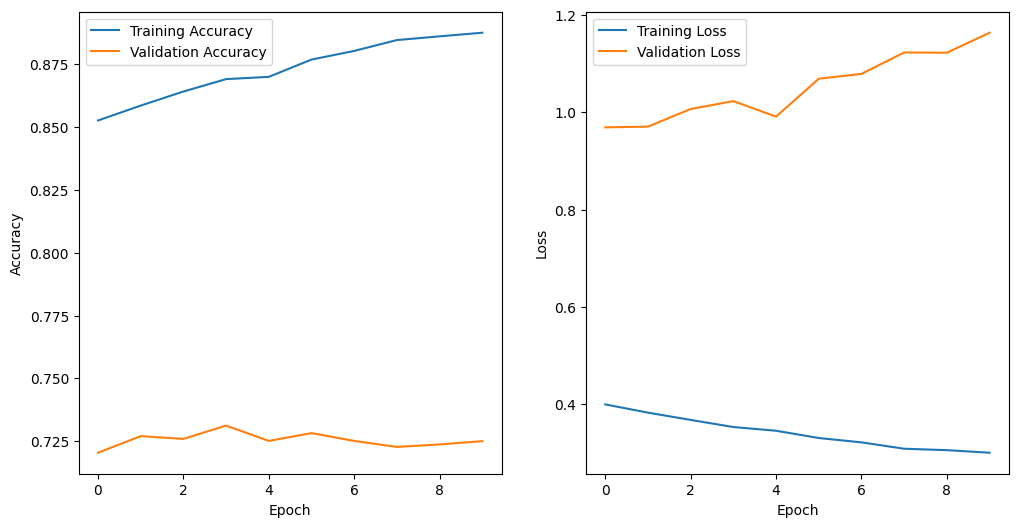

In [111]:
import matplotlib.pyplot as plt

# Plotar curvas de aprendizado
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_2vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_2vgg.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_2vgg.history['loss'], label='Training Loss')
plt.plot(history_2vgg.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Utilizando 3 VGG

In [112]:
# define cnn model
def define_model():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dense(10, activation='softmax'))
 # compile model
 opt = SGD(lr=0.001, momentum=0.9)
 model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
 return model

In [113]:
# fit model
history_3vgg = model.fit(trainX, trainY,
                         epochs=10,
                         batch_size=64,
                         validation_data=(testX, testY),
                         verbose=0)

In [114]:
# Avaliar o modelo
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.3863670825958252
Test accuracy: 0.7260000109672546


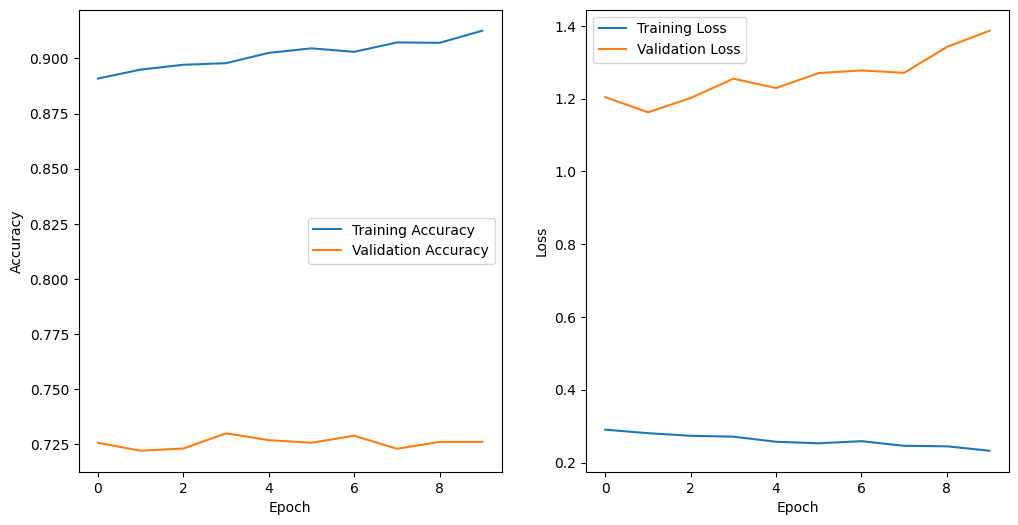

In [115]:
import matplotlib.pyplot as plt

# Plotar curvas de aprendizado
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_3vgg.history['accuracy'], label='Training Accuracy')
plt.plot(history_3vgg.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_3vgg.history['loss'], label='Training Loss')
plt.plot(history_3vgg.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Utilizando 3 VGG com Dropout

In [116]:
# define cnn model
def define_model():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Dropout(0.2))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Dropout(0.2))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Dropout(0.2))
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dropout(0.2))
 model.add(Dense(10, activation='softmax'))
 # compile model
 opt = SGD(lr=0.001, momentum=0.9)
 model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
 return model

In [117]:
# fit model
history_3vgg_dropout = model.fit(trainX, trainY,
                         epochs=10,
                         batch_size=64,
                         validation_data=(testX, testY),
                         verbose=0)

In [119]:
# Avaliar o modelo
score = model.evaluate(testX, testY, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.5222970247268677
Test accuracy: 0.7210999727249146


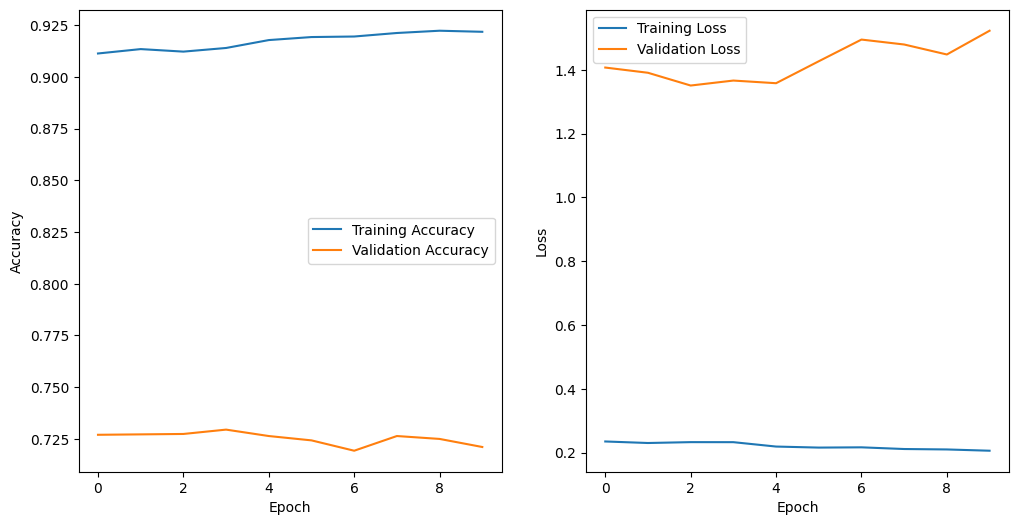

In [120]:
import matplotlib.pyplot as plt

# Plotar curvas de aprendizado
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_3vgg_dropout.history['accuracy'], label='Training Accuracy')
plt.plot(history_3vgg_dropout.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_3vgg_dropout.history['loss'], label='Training Loss')
plt.plot(history_3vgg_dropout.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()